In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sixtyimage/50_image_caption/images/00056.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00030.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00009.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00023.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00037.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00049.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00020.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00051.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00004.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00022.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00034.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00028.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00038.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00052.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00046.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00003.jpg
/kaggle/input/sixtyimage/50_image_caption/images/00014.j

In [138]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from PIL import Image
import os
import glob
from transformers import BertModel
import numpy as np
import matplotlib.pyplot as plt

In [139]:

class ImageTextDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None, bert_model=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Load BERT model only once, not in __getitem__
        if bert_model is None:
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        else:
            self.bert_model = bert_model
        self.bert_model.eval()  # Set the BERT model to evaluation mode

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and transform the image
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load and tokenize the text
        text_path = os.path.join(self.text_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
        with open(text_path, 'r') as file:
            text = file.read().strip()
        encoded_text = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

        # Generate text embeddings
        with torch.no_grad():
            outputs = self.bert_model(**encoded_text)
        text_embeddings = outputs.last_hidden_state[:, 0, :]  # Get the embeddings of the [CLS] token

        return image, text_embeddings


image_folder_path = '/kaggle/input/sixtyimage/50_image_caption/images'
text_folder_path = '/kaggle/input/sixtyimage/50_image_caption/text'

dataset = ImageTextDataset(image_folder_path, text_folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [140]:
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, noise_dim, img_shape=(3, 128, 128)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        # Adjust the input feature size to match the noise_dim + text_embedding_dim
        self.model = nn.Sequential(
            nn.Linear(noise_dim + text_embedding_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        if text_embedding.dim() == 3:
            text_embedding = text_embedding[:, 0, :]
        x = torch.cat((noise, text_embedding), dim=1)
        img = self.model(x)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [143]:
class Discriminator(nn.Module):
    def __init__(self, text_embedding_dim, img_shape=(3, 128, 128)):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(img_shape) + text_embedding_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
            # Removed nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        img_flat = img.view(img.size(0), -1)
        if text_embedding.dim() == 3:
            text_embedding = text_embedding.squeeze(1)
        x = torch.cat((img_flat, text_embedding), dim=1)
        validity = self.model(x)
        return validity


In [153]:
# Initialize the generator and discriminator models for WGAN
generator = Generator(text_embedding_dim=768, noise_dim=100).to(device)
discriminator = Discriminator(text_embedding_dim=768, img_shape=(3, 128, 128)).to(device)


In [162]:
import torch
import torch.autograd as autograd

def compute_gradient_penalty(D, real_samples, fake_samples, text_embedding, device):
    """Calculates the gradient penalty loss for WGAN GP."""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, text_embedding)
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_wgan_gp(generator, discriminator, data_loader, num_epochs, lambda_gp, device):
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(num_epochs):
        for i, (images, texts) in enumerate(data_loader):
            images, texts = images.to(device), texts.to(device)

            # Train Discriminator
            for _ in range(5):  # Update the discriminator more often than the generator
                noise = torch.randn(images.size(0), 100, device=device)
                fake_images = generator(noise, texts).detach()
                real_validity = discriminator(images, texts)
                fake_validity = discriminator(fake_images, texts)
                gradient_penalty = compute_gradient_penalty(discriminator, images.data, fake_images.data, texts, device)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

            # Train Generator
            noise = torch.randn(images.size(0), 100, device=device)
            fake_images = generator(noise, texts)
            fake_validity = discriminator(fake_images, texts)
            g_loss = -torch.mean(fake_validity)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i+1}/{len(data_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save models after each epoch
        torch.save(generator.state_dict(), f"wgenerator_epoch_{epoch}.pth")

# Train the model
train_wgan_gp(generator, discriminator, dataloader, num_epochs=20, lambda_gp=10, device=device)


[Epoch 0/20] [Batch 10/15] [D loss: -588.320068359375] [G loss: -127.08499145507812]
[Epoch 1/20] [Batch 10/15] [D loss: -24.120628356933594] [G loss: -85.26486206054688]
[Epoch 2/20] [Batch 10/15] [D loss: -19.664573669433594] [G loss: -118.19097900390625]
[Epoch 3/20] [Batch 10/15] [D loss: -15.452937126159668] [G loss: 33.9730224609375]
[Epoch 4/20] [Batch 10/15] [D loss: -11.642850875854492] [G loss: -19.835742950439453]
[Epoch 5/20] [Batch 10/15] [D loss: -19.040254592895508] [G loss: -31.004989624023438]
[Epoch 6/20] [Batch 10/15] [D loss: -29.571025848388672] [G loss: -33.605224609375]
[Epoch 7/20] [Batch 10/15] [D loss: -62.144981384277344] [G loss: 96.8194580078125]
[Epoch 8/20] [Batch 10/15] [D loss: -58.975791931152344] [G loss: 79.49386596679688]


KeyboardInterrupt: 

In [145]:
import matplotlib.pyplot as plt

def train_wgan(generator, discriminator, data_loader, num_epochs, clip_value=0.01):
    g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (images, texts) in enumerate(data_loader):
            images, texts = images.to(device), texts.to(device)

            # Train Discriminator
            for _ in range(10):  # Train the discriminator more often
                discriminator.zero_grad()
                noise = torch.randn(images.size(0), 100, device=device)
                gen_imgs = generator(noise, texts)

                real_loss = discriminator(images, texts).mean()
                fake_loss = discriminator(gen_imgs.detach(), texts).mean()
                d_loss = -(real_loss - fake_loss)
                d_loss.backward()
                d_optimizer.step()

                for p in discriminator.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            d_losses.append(d_loss.item())

            # Train Generator
            generator.zero_grad()
            gen_imgs = generator(noise, texts)
            g_loss = -discriminator(gen_imgs, texts).mean()
            g_loss.backward()
            g_optimizer.step()

            g_losses.append(g_loss.item())

            if (i + 1) % 10 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i+1}/{len(data_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")

    return g_losses, d_losses

# Train the model and get the loss history
g_losses, d_losses = train_wgan(generator, discriminator, dataloader, num_epochs=20)


[Epoch 0/20] [Batch 10/15] [D loss: 83.27032470703125] [G loss: -449.8133544921875]
[Epoch 1/20] [Batch 10/15] [D loss: -113.64352416992188] [G loss: 375.942138671875]
[Epoch 2/20] [Batch 10/15] [D loss: 3.53817081451416] [G loss: 12.05219841003418]
[Epoch 3/20] [Batch 10/15] [D loss: -169.39723205566406] [G loss: -159.20620727539062]
[Epoch 4/20] [Batch 10/15] [D loss: -11.287942886352539] [G loss: -24.46535301208496]
[Epoch 5/20] [Batch 10/15] [D loss: -77.01348876953125] [G loss: 360.4367980957031]
[Epoch 6/20] [Batch 10/15] [D loss: -4.826788902282715] [G loss: -10.856854438781738]
[Epoch 7/20] [Batch 10/15] [D loss: -12.189594268798828] [G loss: -35.84186553955078]
[Epoch 8/20] [Batch 10/15] [D loss: -8.676536560058594] [G loss: -59.42472457885742]
[Epoch 9/20] [Batch 10/15] [D loss: -10.267997741699219] [G loss: -32.69370651245117]


KeyboardInterrupt: 

# Error Plot

NameError: name 'g_losses' is not defined

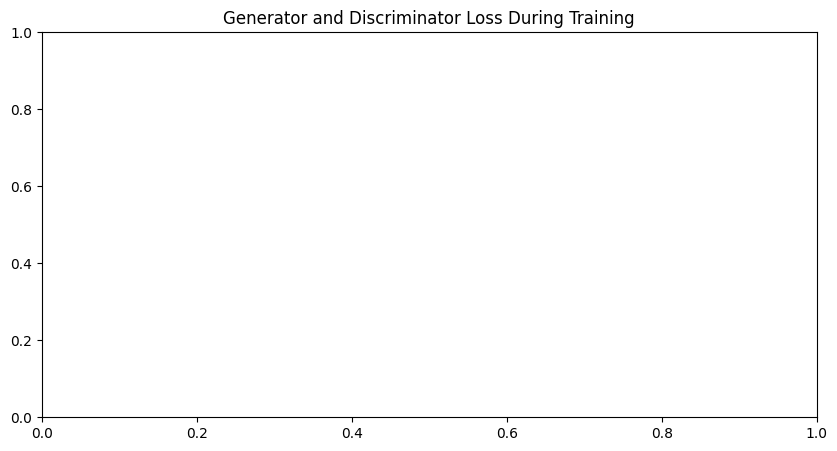

In [118]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G Loss")
plt.plot(d_losses,label="D Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Image

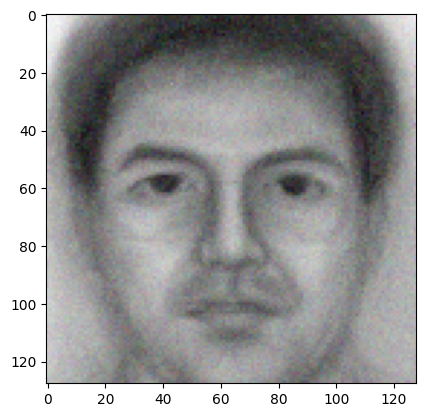

In [176]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt

# Load the generator model
generator = Generator(text_embedding_dim=768, noise_dim=100).to(device)
generator.load_state_dict(torch.load('wgenerator_epoch_6.pth', map_location=device))
generator.eval()
# Load a pretrained BERT model and tokenizer for text embedding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Your text input
text = """ """

# Encode and get the text embeddings
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
with torch.no_grad():
    outputs = model(**inputs)
text_embedding = outputs.last_hidden_state[:, 0, :]  # Taking the embedding of the [CLS] token

# Generate a noise vector
noise = torch.randn(1, 100, device=device)

# Generate an image with the generator
with torch.no_grad():
    generated_image = generator(noise, text_embedding.to(device)).cpu()

image = generated_image.squeeze(0).permute(1, 2, 0)  # Convert from CHW to HWC
image = (image - image.min()) / (image.max() - image.min())  # Rescale pixel values to [0, 1]

plt.imshow(image.numpy())
plt.show()

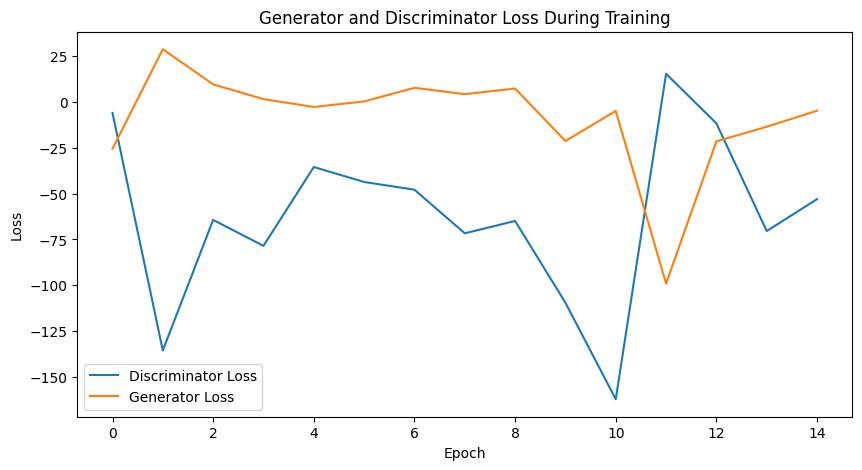

In [125]:
import matplotlib.pyplot as plt

# Sample data from the training logs
epochs = list(range(0, 15))
d_losses = [
    -6.008079528808594, -135.52841186523438, -64.33181762695312, -78.49022674560547,
    -35.48617935180664, -43.64522933959961, -47.85709762573242, -71.64614868164062,
    -64.9085693359375, -109.52388000488281, -162.15087890625, 15.374671936035156,
    -11.673091888427734, -70.41542053222656, -53.00000762939453
]
g_losses = [
    -25.429914474487305, 28.773571014404297, 9.586311340332031, 1.5595440864562988,
    -2.729252338409424, 0.2929314970970154, 7.731663703918457, 4.254229545593262,
    7.328723430633545, -21.31161117553711, -4.912936210632324, -99.08753204345703,
    -21.487415313720703, -13.515480041503906, -4.766434669494629
]

plt.figure(figsize=(10, 5))
plt.plot(epochs, d_losses, label='Discriminator Loss')
plt.plot(epochs, g_losses, label='Generator Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [146]:
!ls

generator_epoch_0.pth	generator_epoch_13.pth	generator_epoch_5.pth
generator_epoch_1.pth	generator_epoch_14.pth	generator_epoch_6.pth
generator_epoch_10.pth	generator_epoch_2.pth	generator_epoch_7.pth
generator_epoch_11.pth	generator_epoch_3.pth	generator_epoch_8.pth
generator_epoch_12.pth	generator_epoch_4.pth	generator_epoch_9.pth


In [161]:
generator = Generator(text_embedding_dim=768, noise_dim=100).to(device)
generator.load_state_dict(torch.load('generator_epoch_9.pth'))
generator.eval()  # Set the model to evaluation mode
#import torch


# Load a pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Your text input
text = "man square face medium hair pair medium normal eyeswith dense thin flat eyebrows mouth thin wide medium short nose ears normal hasnt glasses hasn’t beard "

# Encode and get the text embeddings
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
with torch.no_grad():
    outputs = model(**inputs)
text_embedding = outputs.last_hidden_state[:, 0, :]  # Taking the embedding of the [CLS] token

# Generate a noise vector
noise = torch.randn(1, 100, device=device)  # Assuming noise_dim is 100

# Generate an image
generator.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    generated_image = generator(noise, text_embedding.to(device)).cpu()

# The generated image is now stored in generated_image
image = generated_image.squeeze(0).permute(1, 2, 0)  # Convert from CHW to HWC
image = (image - image.min()) / (image.max() - image.min())  # Rescale pixel values to [0, 1]

plt.imshow(image.numpy())
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/working/generator_epoch_12.pth'

In [ ]:
os.rmdir("/kaggle/working")